In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DirectedGraph import *
from IPython.display import clear_output

In [4]:
dg = DirectedGraph()
import pandas as pd
dg.addState("Rainy").addState("Sunny").set_telep(.1)
dg.addLink("Rainy","Rainy")
#dg.addLink("Rainy","Sunny")
dg.addLink("Sunny","Sunny")
dg.addLink("Sunny","Rainy")
dg.print()
print(dg.stationary())

       Rainy  Sunny
Rainy      1      0
Sunny      1      1
{'Rainy': 0.09090909090909083, 'Sunny': 0.9090909090909092}


In [5]:
skill_data = pd.read_csv("../data/dependent_skill_data.csv")
skill_data

c:\Users\Colton\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3203: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,p1_id,p2_id,p1_char,p2_char,stage,p1_won,p1_games_played,p1_games_won,p2_games_played,p2_games_won
0,3020470,2148147,pikachu,mario,-1,True,46,23,92,56
1,997435,1461662,lucina,duckhunt,-1,False,414,186,589,326
2,2059238,2286649,joker,mario,Final Destination,False,25,10,1654,914
3,1838330,2031257,corrin,hero,Final Destination,False,292,38,318,103
4,1867437,1503263,yoshi,pikachu,Pokémon Stadium 2,False,353,201,80,37
...,...,...,...,...,...,...,...,...,...,...
2963855,1867677,154042,cloud,wolf,Kalos Pokémon League,False,80,38,275,88
2963856,2042895,1581951,kingdedede,bowser,Pokémon Stadium 2,False,453,237,176,101
2963857,1728672,1090846,terry,zerosuitsamus,Battlefield,False,2,0,1224,680
2963858,691176,1735611,cloud,snake,Smashville,True,2103,1114,437,209


In [6]:
dg2 = DirectedGraph().set_telep(.01)
count = 0

def addrow(row):
    global count 
    count += 1
    if count % 1000 == 0:
        clear_output()
        print(count)
    if row["p1_won"]:
        dg2.addLink(row["p2_id"],row["p1_id"], add=True)
    else:
        dg2.addLink(row["p1_id"],row["p2_id"], add=True)

#skill_game_data.apply(addrow,axis=1)

In [7]:
# len(dg2.states)
# Gives 20294

My computer runs out of memory because there are so many states. It caps out around 20,000, so this approach as it is now won't work. One way to resolve this might be to group players into chunks based on how many games they've played, compute the stationary distribution of these smaller chunks, and then combine our results somehow afterwards.

Let's hold this thought for now, though, and try running this directed graph with each of the characters as nodes instead.

In [8]:
dg_char = DirectedGraph().set_telep(.01)
count = 0

def addrowchar(row):
    global count 
    count += 1
    if count % 1000 == 0:
        clear_output()
        print(count)
    if row["p1_won"]:
        dg_char.addLink(row["p2_char"],row["p1_char"], add=True)
    else:
        dg_char.addLink(row["p1_char"],row["p2_char"], add=True)

skill_data[(skill_data["p1_char"] != '-1') & (skill_data["p2_char"] != '-1')].apply(addrowchar,axis=1)

2876000


0          None
1          None
2          None
3          None
4          None
           ... 
2963854    None
2963855    None
2963856    None
2963857    None
2963858    None
Length: 2876270, dtype: object

This runs relatively fast, in about 30 seconds. Let's find the stationary distribution of this markov chain.

In [48]:
dcs = dg_char.stationary()

sortdict = lambda d : sorted(d.items(), key = lambda x: x[1], reverse = True)
sortdict(dcs)

[('joker', 0.03038685604695027),
 ('cloud', 0.025820971964164562),
 ('bowser', 0.025499482559457255),
 ('ness', 0.025001336869813776),
 ('wolf', 0.024717408216298278),
 ('palutena', 0.023589134817502612),
 ('pokemontrainer', 0.021948337327033097),
 ('captainfalcon', 0.019944814617547046),
 ('rob', 0.01963543443170991),
 ('yoshi', 0.019260370440902487),
 ('inkling', 0.01884416151857103),
 ('mario', 0.01862958790362047),
 ('snake', 0.01846395926184079),
 ('pyra', 0.018179126385734823),
 ('lucina', 0.017734356990388372),
 ('donkeykong', 0.017094757749365495),
 ('kingkrool', 0.016740268535154382),
 ('terry', 0.01671725954064742),
 ('link', 0.016282953440333436),
 ('jigglypuff', 0.016141931406021524),
 ('pikachu', 0.015542845280889046),
 ('roy', 0.01543313893035259),
 ('sonic', 0.01493975482014758),
 ('steve', 0.014682236597123558),
 ('luigi', 0.014533335143380692),
 ('kingdedede', 0.014502714315746689),
 ('mrgameandwatch', 0.014236798987192672),
 ('falco', 0.013910513374240974),
 ('byleth'

Interpreting this stationary distribution is tricky. We would like to say the characters with the highest probability are the "best", like we would do with players, however I think it is wrong to say there is an objective "best" ordering to the characters. For example, `pikachu` being good against `ganondorf` and `ganondorf` being good against `jigglypuff` does not *nessecarily* mean `pikachu` will be good against `jigglypuff`. I would argue, on the other hand, that in some sense the players do have this kind of ordering based on skill level, which is why that would be a good place to use this methogolody.

Let's visualize how many players have played a certain number of games.

       player_id  player_games_played
0        2160533                    1
1        1069134                    1
2        3108191                    1
3        1945647                    1
4        1108951                    1
...          ...                  ...
142236   1051067                 6175
142237     24025                 6415
142238    232730                 6552
142239    539670                 7293
142240   1006473                 9191

[142241 rows x 2 columns]


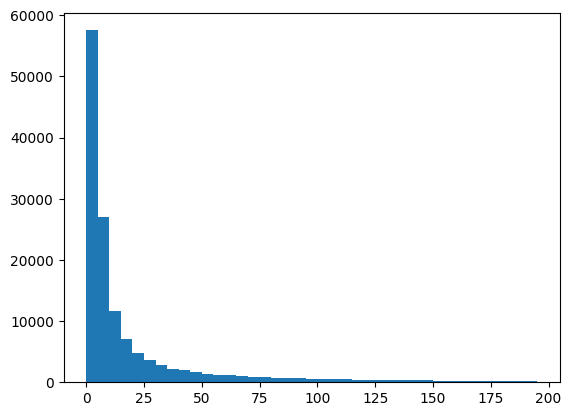

In [28]:
df1 = skill_data[["p1_id","p1_games_played"]].rename(columns = {"p1_id" : "player_id","p1_games_played" : "player_games_played"})
df2 = skill_data[["p2_id","p2_games_played"]].rename(columns = {"p2_id" : "player_id","p2_games_played" : "player_games_played"})
player_games_played_df = df1.append(df2,ignore_index = True).astype({"player_id" : "string", "player_games_played" : "int32"}).drop_duplicates(ignore_index=True).sort_values("player_games_played").reset_index(drop=True)
print(player_games_played_df)
plt.hist(player_games_played_df["player_games_played"].to_list(),bins=range(0,200,5))
plt.show()
#plt.hist(player_games_played_df[player_games_played_df["player_games_played"] >= 200]["player_games_played"].to_list(),bins=range(200,2000,50))
#plt.show() - has same 1/x graph

We see that it seems to follow a 1/x function, which is generally what we should expect from this.

Here is my idea for computing a skill metric:

Divide the dataset into bins of size 100 in increasing order by games played

Find the stationary distribution of each bin. Then, find the stationary distribution of the top 50 of bin 0 and lowest 50 of bin 1, top 50 of bin 1 and lowest 50 of bin 2, ... et cetera.

Repeat this process until sufficiently sorted.

In [117]:
player_games_played_df

,player_id,player_games_played
0,2160533,1
1,1069134,1
2,3108191,1
3,1945647,1
4,1108951,1
...,...,...
142236,1051067,6175
142237,24025,6415
142238,232730,6552
142239,539670,7293


In [133]:
def sortsub(sorting_df, major_df, start, stop):

    player_dg = DirectedGraph().set_telep(.01)

    lsdf = len(sorting_df)
    if stop > lsdf:
        stop = lsdf
    if start < 0:
        start = 0

    lg_plys = sorting_df.iloc[start:stop]["player_id"].to_list()

    def func_row(row):
        if row["p1_won"]:
            player_dg.addLink(row["p2_id"],row["p1_id"],add=True)
        else:
            player_dg.addLink(row["p1_id"],row["p2_id"],add=True)

    mdfapp = major_df[major_df["p1_id"].isin(lg_plys) & major_df["p2_id"].isin(lg_plys)]

    if mdfapp.empty:
        print("here")
        return lg_plys

    mdfapp.apply(func_row,axis=1)
    
    pdgs = player_dg.stationary()

    return sorted(pdgs.keys(), key = lambda x: pdgs[x], reverse = True)

def onepass(sorting_df,major_df):
    step = -100
    cursor = len(sorting_df)
    output = []
    while cursor > 0:
        clear_output()
        print(cursor)
        output += sortsub(sorting_df,major_df,cursor+step,cursor)
        cursor += step
    return output

onepass(sorting_df=player_games_played_df,major_df=skill_data)


41
here


TypeError: cannot do positional indexing on RangeIndex with these indexers [142291.0] of type float64

After seeing how slow this was, I don't think this is a good approach...